# PACKAGES

In [47]:
import pandas as pd
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import numpy as np
from scipy.spatial.distance import cdist
from shapely.ops import cascaded_union
from shapely.ops import unary_union
import geovoronoi as gv
import geovoronoi.plotting as gvplt
import seaborn as sns
from shapely.geometry import Polygon
from sklearn.neighbors import BallTree

# DATA COLLECTION

In [48]:
masterlist_filename = 'landbank.json'

In [49]:
def nearby(ind, dist, df, branch_index):
    listing = ind[j]
    for indx, i in enumerate(listing):
        prnt_dist = dist[j][indx]*earth_radius
        print('%.0fm'%prnt_dist, df.at[i, 'type_id'], 
          df.at[i, 'address'], df.at[i, 'latitude'], df.at[i, 'longitude'], i, df.at[i, 'id'])
    return 0

In [50]:
df = pd.read_json(masterlist_filename)
df = df.T
df.sort_index(inplace=True)
df.at[13, 'latitude'] = '15.308691'
df.at[460, 'latitude'] = '14.6507700'
df.at[460, 'longitude'] = '120.9721620'
df.at[610, 'latitude'] = '14.6492420'
df.at[610, 'longitude'] = '121.0692769'
df.at[5551, 'latitude'] = '15.5328227'
df.at[5551, 'longitude'] = '119.9570529'
df.drop(df[df.status_id == 0].index, inplace=True)
df.reset_index(inplace=True)

In [51]:
known = [477, 0, 2316, 168, 55]
type_id_label = {1: 'branch and branch-lite', 2: 'LEAF', 3: 'atm', 4: 'cash-deposit machines', 5: 'lending center'}
#411Branches and 66 branch-lite units, 55 Lending Centers and 2,316 ATMs and 168 CDMs 
for i in range(1,6):
    print(i, df[df.type_id ==i].shape, known[i-1])

1 (449, 20) 477
2 (47, 20) 0
3 (2150, 20) 2316
4 (120, 20) 168
5 (57, 20) 55


In [52]:
print(df.shape)
df.tail(5)

(2823, 20)


,index,id,fid,maker_id,checker_id,type_id,region_id,province_id,city_id,status_id,name,address,email,number,fax,longitude,latitude,remarks,created_at,updated_at
2818,5542,5542,0,28,9,1,7,37,682,1,Barotac Viejo (Iloilo) Agri Hub,"Barotac Viejo Trade Center, Zulueta Drive, Bar...",AGRI_BVIEJO@mail.landbank.com,(033) 337-3632,None,122.8497443,11.0392085,None,2021-02-26 14:48:01,2021-03-05 09:13:38
2819,5546,5546,0,28,9,1,7,38,1039,1,Himamaylan Branch Lite,"GM Building, Rizal Street, Barangay 2, Poblaci...",BR_HIMAMAYLAN@mail.landbank.com,(034) 388-3777,None,122.9665772,10.2054372,None,2021-02-26 15:17:50,2021-03-05 09:35:47
2820,5549,5549,0,28,9,1,11,55,984,1,Tangub (Misamis Occidental) Branch,"2nd North corner Magsaysay Street, Barangay II...",BR_TANGUB@mail.landbank.com,(088) 531-3113,None,123.7500494,8.0635912,None,2021-02-26 15:37:21,2021-03-05 09:39:18
2821,5551,5551,0,28,0,1,3,16,1552,2,Masinloc (Zambales) Branch,"National Highway, Barangay Inhobol, Masinloc, ...",BR_MASINLOC@mail.landbank.com,(0966) 239-5481,None,119.9570529,15.5328227,None,2021-03-05 15:00:45,2021-03-05 15:00:45
2822,5552,5552,0,28,0,1,8,39,269,2,Tubigon (Bohol) Branch,"B. Cabangbang Avenue, Barangay Potohan, Tubigo...",BR_TUBIGON@mail.landbank.com,(038) 237-2658,None,123.9484996,9.9360606,None,2021-03-05 15:11:42,2021-03-05 15:11:42


In [53]:
df[df.type_id == 2].id
df[df.id == 5508]
df[df.city_id == 774]

,index,id,fid,maker_id,checker_id,type_id,region_id,province_id,city_id,status_id,name,address,email,number,fax,longitude,latitude,remarks,created_at,updated_at
2017,2181,2181,0,50,68,4,1,3,774,1,CDM LEAF Pugo,"'Poblacion West, Pugo, La Union",N/A,N/A,N/A,120.4677679,16.3123097,None,2019-09-24 16:39:51,2019-09-25 10:29:46
2188,2683,2683,0,50,68,3,1,3,774,1,LEAF Pugo,"Poblacion West, Pugo, La Union",None,N/A,N/A,120.4656775,16.3203602,None,2019-09-25 14:48:33,2019-09-27 16:35:41
2800,5508,5508,0,28,9,2,1,3,774,1,Pugo (La Union) LEAF,"Poblacion West, Pugo, La Union",leaf_pugo@mail.landbank.com,(0917) (0917)-503-7581,None,120.4764692,16.3195419,None,2019-10-03 17:08:19,2019-10-03 17:16:06


In [54]:
print(len(df['province_id'].unique()), len(df['city_id'].unique()))

81 692


In [55]:
long = df['longitude'].astype(float)
lat = df['latitude'].astype(float)
geometry = [Point(xy) for xy in zip(long, lat)]
geo_df = gpd.GeoDataFrame(geometry = geometry)
geo_df = geo_df.set_crs(epsg=4326)

#geo_df.crs = {'init':"epsg:4326"}

In [56]:
# ax = geo_df.plot(color="red", markersize=0.2, figsize=(20, 20))
# #cx.add_basemap(ax, crs=geo_df.crs.to_string())
# # plot the marker
# cx.add_basemap(ax, crs=geo_df.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [57]:
# nightlights = cx.providers.NASAGIBS.ViirsEarthAtNight2012
# philippines = cx.Place("Philippines", source=nightlights)
# philippines.plot()

In [58]:
df[df['city_id'] == 17] #14 QC

,index,id,fid,maker_id,checker_id,type_id,region_id,province_id,city_id,status_id,name,address,email,number,fax,longitude,latitude,remarks,created_at,updated_at
41,43,43,0,28,9,1,16,77,17,1,Valenzuela Branch,ARCA North Corporate Center Building #150 F. D...,BR_VLNZUELA@mail.landbank.com,(02) 8292-1971;8292-3688;8292-0114,(02) 8292-1478,120.98321758320519,14.701266365738643,None,2019-06-18 17:04:37,2021-03-05 09:11:25
415,417,417,0,50,68,3,16,77,17,1,Valenzuela Medical Center,"Padrigal Street, Karuhatan, Valenzuela City",N/A,N/A,N/A,120.8990212,14.692362,None,2019-06-20 13:29:18,2019-09-27 13:42:47
417,419,419,0,50,68,3,16,77,17,1,Valenzuela LGU 2,"Valenzuela LGU, Poblacion, Valenzuela City",N/A,N/A,N/A,120.9605635,14.689741,None,2019-06-20 13:30:38,2019-09-27 13:42:42
418,420,420,0,50,68,3,16,77,17,1,Valenzuela LGU 1,"Valenzuela LGU, Poblacion, Valenzuela City",N/A,N/A,N/A,120.9605635,14.689741,None,2019-06-20 13:31:32,2019-09-27 13:41:56
420,422,422,0,50,68,3,16,77,17,1,Valenzuela,"GBT Bldg. Oreta Subd., Maysan Road corner G. T...",N/A,N/A,N/A,120.969059,14.692362,None,2019-06-20 13:33:46,2019-09-27 13:41:50
1950,2110,2110,0,50,68,3,16,77,17,1,Brgy. Punturin,Valenzuela LGU's 3S Center 150 P. Faustino St....,None,N/A,N/A,120.9878149,14.7410312,None,2019-09-24 15:09:18,2019-09-27 13:42:01
1951,2111,2111,0,50,68,3,16,77,17,1,3S Center Marulas,"3S Center, Brgy. Marulas, Valenzuela City",None,N/A,N/A,120.9806544,14.6739805,None,2019-09-24 15:10:28,2019-09-27 13:42:22
1952,2112,2112,0,50,68,3,16,77,17,1,Brgy. Ugong,"3S Center Brgy Ugong,GF Que Grande St. Ugong, ...",None,N/A,N/A,121.0069227,14.6941205,None,2019-09-24 15:11:12,2019-09-27 13:42:27
1953,2113,2113,0,50,68,3,16,77,17,1,Brgy. GT De Leon,"3S Center M. Delos Reyes, Brgy Gen. T De Leon,...",None,N/A,N/A,120.9887583,14.6853377,None,2019-09-24 15:12:16,2019-09-27 13:42:33
1954,2114,2114,0,50,68,3,16,77,17,1,Finance Center Valenzuela LGU,"Mc Arthur Highway, Malinta, Valenzuela",None,N/A,N/A,120.9668703,14.6923672,None,2019-09-24 15:13:57,2019-09-27 13:42:08


In [59]:
df[df['id'] == 610] #610]

,index,id,fid,maker_id,checker_id,type_id,region_id,province_id,city_id,status_id,name,address,email,number,fax,longitude,latitude,remarks,created_at,updated_at
595,610,610,0,50,68,3,16,77,14,1,UP Diliman College of Arts & Sciences,"College of Arts and Sciences, UP Diliman Campu...",N/A,N/A,N/A,121.0692769,14.6492420,None,2019-06-20 16:50:21,2019-09-27 11:33:05


In [60]:
df[pd.to_datetime(df['updated_at']).apply(lambda x: x.year)==2021]

,index,id,fid,maker_id,checker_id,type_id,region_id,province_id,city_id,status_id,name,address,email,number,fax,longitude,latitude,remarks,created_at,updated_at
41,43,43,0,28,9,1,16,77,17,1,Valenzuela Branch,ARCA North Corporate Center Building #150 F. D...,BR_VLNZUELA@mail.landbank.com,(02) 8292-1971;8292-3688;8292-0114,(02) 8292-1478,120.98321758320519,14.701266365738643,None,2019-06-18 17:04:37,2021-03-05 09:11:25
281,283,283,0,28,9,1,15,73,944,1,Parang Branch,"Cor. Mangga and Durian Streets, Poblacion 1, ...",BR_PARANG@mail.landbank.com,(064)\t425-0035 / 425-0160,425-0035,124.2268932,7.38543,None,2019-06-19 16:28:45,2021-03-05 09:45:45
295,297,297,0,28,9,1,13,63,1415,1,Gen. Santos (Gaisano) Branch,"G/F, Vensu Building, National Highway, General...",BR_GNSNGAISANO@mail.landbank.com,(083)\t887-4896 / 552-6075 / 302-6490,552-6075 / 302-6490,125.1842295,6.1160405,None,2019-06-19 16:52:04,2021-03-05 09:41:07
349,351,351,0,28,9,1,16,77,12,1,Ortigas Center-Pearl Drive Branch,"Ground Floor, Tycoon Center Bldg., Pearl Drive...",BR_ORTIGASCTR@mail.landbank.com,(02) 8584-9694,(02) 8584-9692,121.0608533,14.5814685,None,2019-06-20 11:09:06,2021-03-05 09:05:08
1386,1450,1450,0,27,8,5,2,7,717,1,Southern Isabela LC,"2nd Floor Isabela Trade Center San Fermin, Cau...",lbpisabelalc@yahoo.com,"(078) 652 1859, 09088996144",(078) 652-0281,121.767341,16.937539,None,2019-06-24 10:22:09,2021-03-23 10:13:56
1396,1460,1460,0,27,8,5,6,29,380,1,Camarines Sur LC,"2/F LBP Building, Panganiban Drive cor. Magsay...",lbp_nagalc@yahoo.com,(054) 473-3264 / (054) 473-2047,(054) 473-7924,123.19981439999992,13.6278548,None,2019-06-24 11:03:15,2021-03-23 10:13:49
2803,5523,5523,0,27,8,5,1,1,635,1,Ilocos Norte LC,"Venvi IT Park, Ground Floor, Accenture Bldg.Va...",ilocosnortelc@gmail.com,(077) 604-0455,(077)604-0422,18.1807908,120.5917434,None,2021-01-14 13:46:46,2021-03-23 10:14:10
2804,5524,5524,0,27,8,5,2,7,717,1,Northern Isabela LC,"2nd Floor Isabela Trade Center San Fermin, Cau...",southern.isabelalc@yahoo.com,(078) 652 0281,None,121.767341,16.937539,None,2021-01-15 09:40:49,2021-03-23 10:14:03
2805,5527,5527,0,27,8,5,7,34,116,1,Antique LC,"T.A. Fornier st., San Jose, Antique",None,(036) 540 - 9556,None,10.7451364,121.9374064,None,2021-01-15 09:49:37,2021-03-23 10:13:40
2806,5528,5528,0,27,8,5,9,45,876,1,Southern Leyte LC,"2nd Floor, ABC Building, Apo Street, Ormoc City",southernleytelc@yahoo.com,(053) 561 - 3923,None,11.0122532,124.6041615,None,2021-01-15 10:11:22,2021-03-23 10:13:34


In [61]:

earth_radius = 6371000 # in m
test_radius = 50   # in m 

long = np.pi/180*df['longitude'].astype(float)
lat = np.pi/180*df['latitude'].astype(float)
X = [xy for xy in zip(long, lat)]
tree = BallTree(X, metric='haversine')              
dist, ind = tree.query(X, k=20)                
#dist, ind = tree.query_radius(X, r=test_radius/earth_radius, return_distance=True)                

In [62]:
# j =  595
# nearby(ind, dist, df, j)

# FUNCTIONS

In [63]:
def vor_geom_calc(city_boundary,join): #This function generates the voronoi regions
    global vor
    global lb_coords
    city_boundary_shape = cascaded_union(city_boundary.geometry)
    lb_coords = gv.points_to_coords(join.geometry)
    vor = gv.voronoi_regions_from_coords(lb_coords, city_boundary_shape)

def plot_vor(z,s): # This function plots the voronoi regions
    test_df = pd.DataFrame([z[0]]).T
    test_df
    test_gpd = gpd.GeoDataFrame(test_df,geometry=0)
    fig, ax = plt.subplots(figsize=(12, 12))
    test_gpd.plot(ax=ax, cmap = 'Blues')
    s.plot(ax=ax, color = 'black', markersize = 0.2)
    plt.rcParams.update({'font.size': 13})
    # plt.xlabel('Latitude ($^{\circ}$)')
    # plt.ylabel('Longitude ($^{\circ}$)')

def overlay(city_boundary,geo_df,join): #This functons overlays data points on to the map to ensure obedience to boundaries
    city_boundary = city_boundary.to_crs(epsg=4326)
    geo_df = geo_df.to_crs(city_boundary.crs)
    gpd.GeoDataFrame(city_boundary)
    overlay(city_boundary,geo_df)
    
def map_plot(city_boundary, boundary): #This function plots the overlain points on the map
    fig, ax = plt.subplots(figsize=(12,12))
    city_boundary.plot(ax=ax, color="gray")
    xmin, ymin, xmax, ymax = boundary.total_bounds
    join.cx[xmin:xmax,ymin:ymax].plot(ax=ax, markersize=0.8, color="black", label ="ATM Branch")
    plt.axis('equal')
    plt.legend(loc='lower right')
    # plt.title('LandBank Branches')
    # plt.xlabel('Latitude ($^{\circ}$)')
    # plt.ylabel('Longitude ($^{\circ}$)')
    plt.show()

def vor_area_calc(area_df,vor): #This function calculates the area of each polygon
    vor_geom = []
    if len(vor[0])>3:
        for i in range(len(vor[0])):
            vor_geom.append(vor[0][i])
        area_df['geometry']=vor_geom
    elif len(vor[0])==3:
        for i in range(3):
            vor_geom.append(vor[0][i])
        area_df['geometry']=vor_geom
    elif len(vor[0])==2:
        for i in range(2):
            vor_geom.append(vor[0][i])
        area_df['geometry']=vor_geom
    elif len(vor[0])==1:
        for i in range(1):
            vor_geom.append(vor[0][i])
        area_df['geometry']=vor_geom
    elif len(vor[0])==0:
        print('No branches in this area')


def area_plot(area_df): #This function plots a histogram of the areas of voronoi regions
    plt.hist(area_df['area'], color = 'red')
    plt.ylabel("Frequency")
    plt.xlabel("Tessellation areas [km\u00b2]")
    # plt.title("Histogram of Voronoi Region Areas")
    plt.show()

def distance_hist(distances): #This function plots a histogram of the distances between points and nearest voronoi centroid
    plt.hist(distances, bins=10, color = 'red')
    plt.xlabel("Next nearest centroid distances [m]")
    plt.ylabel("Frequency")
    # plt.title("Histogram of distance between every Landbank ATM branch and nearest Voronoi centroid")
    plt.show()

def hist2d(centroid_distances): #This function plots a 2d histogram of the distances between points and nearest voronoi centroid to the voronoi region areas
    plt.hist2d(area_df['area'], centroid_distances, bins =[30, 30], cmap='Reds')
    # plt.title("2D Histogram of Centroid Distances and Voronoi Areas")
    plt.colorbar(label='Frequency')
    plt.ylabel('Centroid to Branch Distances [m]') 
    plt.xlabel('Tessellation Areas[km\u00b2]') 
    plt.show()

def centroid_hist(centroid_distances): #This function plots a histogram of the distances between voronoi centroids and nearest point
    plt.hist(centroid_distances, bins=10, color = 'red')
    plt.xlabel("Distance between next nearest centroid and Landbank branch [m]")
    plt.ylabel("Frequency")
    # plt.title("Histogram of distance between nearest Voronoi centroid and every Landbank ATM branch")

def jointplot(area_df,centroid_distances): #This functions plots a 2d joint plot (histogram) of the distances between points and nearest voronoi centroid to the voronoi region areas
    ax = sns.jointplot(x=area_df["area"], y=centroid_distances, kind='hex', cmap = 'Reds', color = 'r')
    plt.xlabel('Tessellation Areas[km\u00b2]')
    plt.ylabel("Vornoid Centroid to Branch Distances [m]")
    plt.colorbar(label='Frequency',orientation="vertical")
    plt.show()

def frac_calc(distances,lim): #This function calculates the percentage of points which are less than or equal to 500 meters away from a Voronoi centroid
    fraction = 0
    count = 0
    for i in range(len(distances)):
        if distances[i] <= lim:
            count+=1
    fraction = round((count/len(distances)*100),2)
    print(fraction,"% of the branches are less than or equal to", lim, "meters away from a centroid.")

def min_dist(dist_matrix): #This function gets the nearest neighbor across the entire dist matrix pairings
    global distances
    global centroid_distances
    distances = []
    centroid_distances = []
    trans = dist_matrix.T
    for i in range(len(join)):
        val = trans[i].min()
        distances.append(val)
    for i in range(len(vor[0])):
        c_val = dist_matrix[i].min()
        centroid_distances.append(c_val)

def dist_matrix_calc(join, area_df): #This function generates a distance matrix across all voronoi centroid-branch point pars
    global dist_matrix
    global branches
    global centroids
    branches = pd.DataFrame()
    centroids = pd.DataFrame()
    centroid = area_df['geometry'].centroid
    join.crs = 'epsg:4326'
    join= join.to_crs(epsg = 3857)
    branches['X'] = join['geometry'].x
    branches['Y'] = join['geometry'].y
    branches.reset_index(drop=True, inplace=True) #created x,y dataframes epsg:3857
    centroids['X'] = centroid.x
    centroids['Y'] = centroid.y
    centroids.reset_index(drop=True, inplace=True) #created x,y dataframes epsg:3857
    branches_array = branches[["X", "Y"]].to_numpy()
    centroids_array = centroids[["X", "Y"]].to_numpy()
    d = cdist(branches_array, centroids_array, 'euclidean')
    dist_matrix = pd.DataFrame(d)

def ccdf(x,label):
    data = x
    data_sorted = np.sort(data)
    p = 1. * np.arange(len(data))/(len(data)-1)
    fig = plt.figure()
    plt.plot(data_sorted,p, color = 'red')
    plt.ylabel('CDF')
    plt.xlabel(label)
    plt.yscale('log')
    plt.xscale('log')
    plt.gca().invert_yaxis()
    plt.gca().set_aspect('equal', adjustable='box')




    
#FURTHER INIT
area_df=gpd.GeoDataFrame()


x_pts = [2.0,3.8,5.0,7.7,8.0]
y_pts = [2.0,8.2,5.0,2.4,7.6]

gpd.points_from_xy(x_pts,y_pts)
geom = gpd.points_from_xy(x_pts,y_pts)
gpd.GeoDataFrame(geometry=geom)
s = gpd.GeoDataFrame(geometry=geom)

box = Polygon([(0,0),(0,10),(10,10),(10,0),(0,0)])
coords = gv.points_to_coords(s.geometry)
z = gv.voronoi_regions_from_coords(coords, box)



# VORONOI ANALYSIS

In [64]:
boundary = gpd.read_file("PHL_adm1.shp")
city_boundary = boundary.loc[[46],'geometry']
join = gpd.sjoin(geo_df, gpd.GeoDataFrame(city_boundary), op='within')
join = join.drop(columns=['index_right'])

poly = unary_union(city_boundary.iloc[0])
ncr_index = np.argmax([x.area for x in poly])
ncr_shp = poly[ncr_index]

C:\ProgramData\Anaconda3\envs\ox\lib\site-packages\IPython\core\interactiveshell.py:3301: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
C:\Users\elmo\AppData\Local\Temp\ipykernel_12252\3640005125.py:7: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  ncr_index = np.argmax([x.area for x in poly])
C:\Users\elmo\AppData\Local\Temp\ipykernel_12252\3640005125.py:8: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  ncr_shp = poly[ncr_index]


In [65]:
ncr_boundary = gpd.GeoSeries(ncr_shp)

In [66]:
# ncr_boundary.to_crs(geo_df.crs)
# join = gpd.sjoin(geo_df, gpd.GeoDataFrame(ncr_boundary), op='within') # if cities
# join = join.drop(columns=['index_right'])

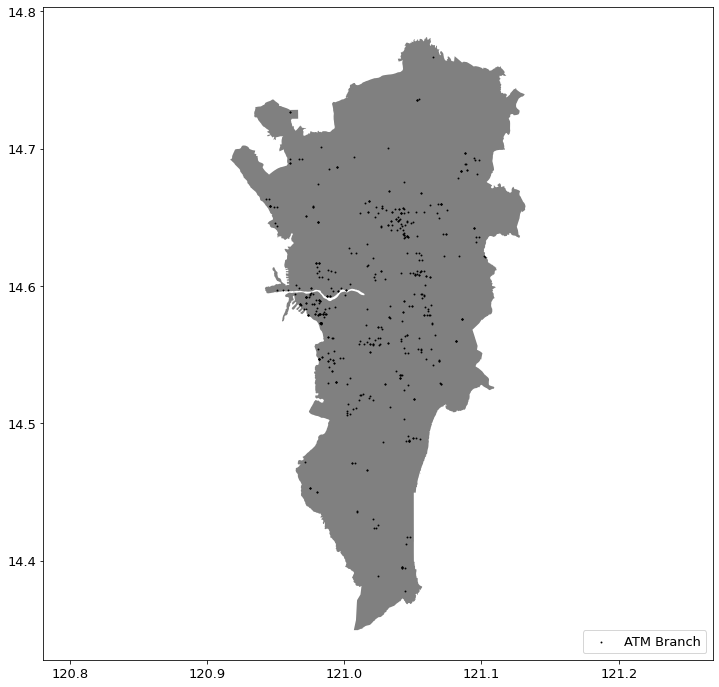

In [67]:
map_plot(ncr_boundary,boundary)

C:\Users\elmo\AppData\Local\Temp\ipykernel_12252\2596246727.py:4: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  city_boundary_shape = cascaded_union(city_boundary.geometry)


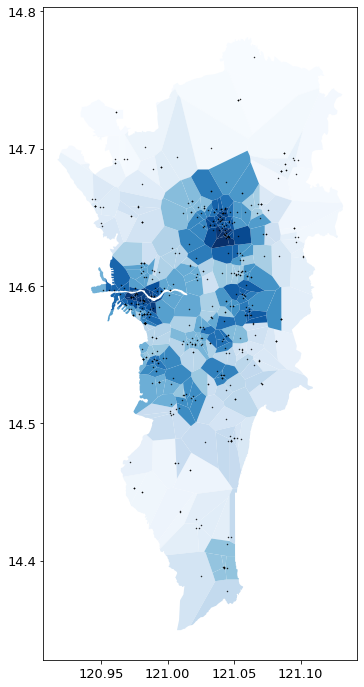

In [68]:
vor_geom_calc(ncr_boundary,join)
plot_vor(vor,join)

In [69]:
vor_area_calc(area_df,vor)

In [70]:
#We convert the areas to epsg 3857 to yield areas in sq. km
test = area_df.copy()
test.crs = 'epsg:4326'
test= test.to_crs(epsg = 3857)
test.crs
area_df = test
area_df["area"] = area_df['geometry'].area/ 10**6 #now to km^2

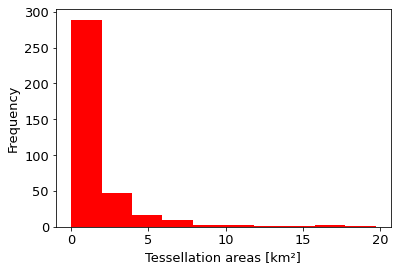

In [71]:
area_plot(area_df)

In [72]:
dist_matrix_calc(join,area_df)

In [73]:
dist_matrix

,0,1,2,3,4,5,6,7,8,9,...,364,365,366,367,368,369,370,371,372,373
0,14367.195215,17075.650822,17159.623083,14449.091149,14120.431931,15895.570286,13175.512547,8923.294555,13499.703507,11383.451254,...,3714.508917,3808.831464,3106.121340,3117.846206,2614.031206,3293.647201,3246.622885,3492.254487,3450.022847,2924.929873
1,14645.711022,17360.057795,17177.599565,14663.504996,14120.594644,15860.869083,13177.264754,9280.614678,13841.845554,11575.924631,...,3866.516382,3907.894669,3250.047284,3273.641453,2783.498695,3418.467727,3387.566052,3662.853122,3562.323586,2997.427591
2,5680.281657,8030.614226,15541.811118,7758.501362,13616.308136,15896.988915,12884.796352,2913.696512,3972.827052,6449.315399,...,7458.565433,7984.266370,7839.427881,7732.188263,7926.989177,7918.639729,7794.441791,7388.905729,7972.154937,8510.634157
3,12919.426778,15636.550274,16003.845028,12973.476373,13022.256366,14895.881537,12076.423442,7929.976951,12279.836748,9920.394791,...,2338.144704,2561.144727,1770.262520,1752.032224,1240.453686,1999.049018,1911.705541,2083.773213,2182.093100,1825.755988
4,13413.928590,16122.938128,16533.219476,13525.844724,13536.481997,15385.086563,12590.368379,8144.910776,12620.014129,10483.084773,...,2902.097002,3095.756769,2323.101046,2311.879434,1798.733509,2542.632016,2465.226009,2651.882583,2719.669941,2303.293493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,9930.772244,12672.361196,12655.357025,9457.350173,9833.575469,11893.162381,8905.799976,7517.338009,10586.725444,6316.487580,...,1421.327908,1625.685760,2039.689952,2005.433235,2497.093691,1919.430450,1909.671345,1617.460635,1835.416617,2493.792338
478,20875.519475,23540.134135,16598.242340,19310.683590,13694.154466,14150.884230,13032.221776,18165.725910,21930.302515,16199.808782,...,10524.402095,9980.729118,10223.095020,10337.894455,10279.641485,10099.924330,10240.853740,10631.256002,10020.965495,9551.539557
479,20403.349958,23089.806076,16731.214136,18973.309814,13759.691184,14360.375200,13053.009241,17414.686906,21280.475853,15825.502481,...,9852.333037,9326.749537,9518.823548,9632.072389,9544.754145,9409.702868,9545.033459,9942.038583,9342.225042,8844.264011
480,16376.824607,18530.855473,7388.921101,13516.614370,5115.952190,4719.132744,4940.346091,17943.679798,19624.089503,11294.233973,...,11041.771427,10509.187598,11290.267678,11378.254595,11742.341967,11034.594122,11188.454802,11330.006844,10842.495753,10952.038644


In [74]:
min_dist(dist_matrix)

In [77]:
centroid_distances_km = [val/1000 for val in centroid_distances]

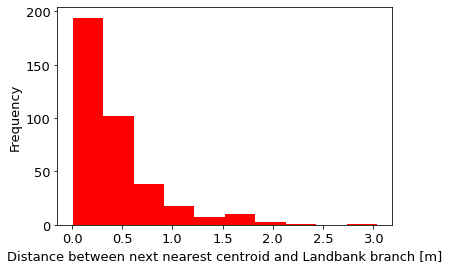

In [78]:
centroid_hist(centroid_distances_km)

194.0

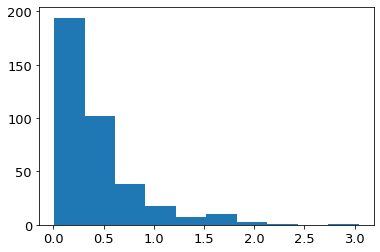

In [79]:
centroid_peak,centroidx,_ = plt.hist(centroid_distances_km);
centroid_peak = centroid_peak.max()
centroid_peak

289.0

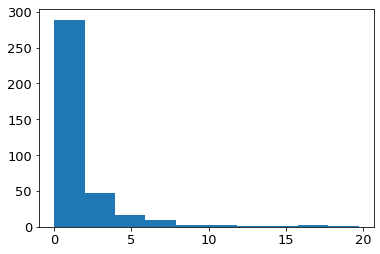

In [80]:
area_peak,areax,_ = plt.hist(area_df['area'])
area_peak = area_peak.max()
area_peak

In [81]:
area_list = area_df['area'].tolist()
len(area_list)

374

In [85]:
data = pd.DataFrame()
data['coverage_area']=area_list
data['backup_distance']=centroid_distances_km

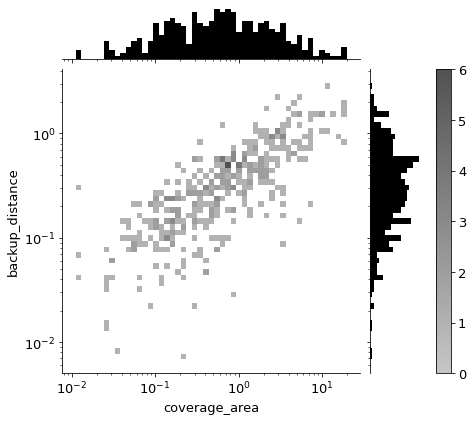

In [89]:
#plotting

# import scipy.stats

# plot_data=data
# nbins = 50
# N = len(plot_data)
# bins1 = np.geomspace(min(plot_data['coverage_area']), max(plot_data['coverage_area']), nbins)
# bins2 = np.geomspace(min(plot_data['backup_distance']), max(plot_data['backup_distance']), nbins)
# g = sns.JointGrid(x='coverage_area', y='backup_distance', data=plot_data)
# g.plot_joint(sns.histplot, bins=[bins1, bins2],cbar = True,color='black')
# # plot on the marginal axis x
# g.ax_marg_x.hist(plot_data['coverage_area'], bins=bins1, color='black')
# # plot on the marginal axis x
# g.ax_marg_y.hist(plot_data['backup_distance'], orientation="horizontal", bins=bins2, color='black')
# # get the current positions of the joint ax and the ax for the marginal x
# pos_joint_ax = g.ax_joint.get_position()
# pos_marg_x_ax = g.ax_marg_x.get_position()
# # reposition the joint ax so it has the same width as the marginal x ax
# g.ax_joint.set_position([pos_joint_ax.x0, pos_joint_ax.y0, pos_marg_x_ax.width, pos_joint_ax.height])
# # reposition the colorbar using new x positions and y positions of the joint ax
# g.fig.axes[-1].set_position([1, pos_joint_ax.y0, .07, pos_joint_ax.height])

# g.ax_joint.set_xscale('log')
# g.ax_joint.set_yscale('log')

In [ ]:
lb = lb_coords.tolist()

In [ ]:
lb = pd.DataFrame(lb_coords)

In [ ]:
lb["points"] = lb[0].astype(str) + lb[1].astype(str)

In [ ]:
lb = lb['points'].value_counts().rename_axis('unique_values').reset_index(name='count')

In [ ]:
lb['unique_values']
lb.rename(columns={'unique_values':'points'})

In [ ]:
lb_coords[481]

In [ ]:
lb_coords[480]

In [ ]:
181/2

In [ ]:
len(branches)

In [ ]:
# fig, ax = plt.subplots(figsize = (10,10))
# area_df.plot(column = 'area', ax=ax, cmap = 'Reds_r',legend = True)
# ax.set_title('Tessellation Areas')
# plt.show()

In [ ]:
ccdf(centroid_distances,'Distance between next nearest centroid [m]')

In [ ]:
ccdf(area_df['area'],'Tessellation Areas [km\u00b2]')

In [ ]:
powerlaw.distribution_compare?

In [ ]:
import powerlaw
results = powerlaw.Fit(centroid_distances)
print(results.power_law.alpha)
print(results.power_law.xmin)
R_centroid, p_centroid = results.distribution_compare('power_law', 'lognormal')

In [ ]:

import powerlaw
results = powerlaw.Fit(area_df['area'])
print(results.power_law.alpha)
print(results.power_law.xmin)
R_area, p_area = results.distribution_compare('power_law', 'lognormal')

In [ ]:
fit = powerlaw.Fit(centroid_distances_km,discrete=True, xmax=1000)
ax1 = fit.plot_ccdf(color='r', label=r"Empirical, $x_{max}=1000$")
fit.power_law.plot_ccdf(color='r', linestyle='--', ax=ax1, label=r"Fit, $x_{max}=1000$")
plt.ylabel('CDF')
plt.xlabel('Distance between next nearest centroid [km]')

In [ ]:
powerlaw.plot_ccdf(np.sort(centroid_distances_km),color='red')
plt.ylabel('CDF')
plt.xlabel('Distance between next nearest centroid [km]')
plt.gca().set_aspect('equal', adjustable='box')



In [ ]:
powerlaw.plot_ccdf(np.sort(area_df['area']),color='red')
plt.ylabel('CDF')
plt.xlabel('Tessellation Areas [km\u00b2]')
plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
fit = powerlaw.Fit(area_df['area'], discrete=True)
####
fit.distribution_compare('power_law', 'lognormal')
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data', marker = 'o', linestyle='None')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"CDF")
fig.set_xlabel("Tessellation Areas [km\u00b2]")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)
fig.annotate(f"R: {round(R_area,2)}\np-value: {round(p_area,2)}",
                    xy=(0.72, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'square', 'fc':'white'})



fit = powerlaw.Fit*area_df['Areas']

In [ ]:
#R = ratio first:second distributions
#high p value - can still be part of Null model (do not reject)
#p value - chance that measurement is part of the distribution

In [ ]:
fit = powerlaw.Fit(centroid_distances, discrete=True)
####
fit.distribution_compare('power_law', 'lognormal')
fig = fit.plot_ccdf(linewidth=3, label='Empirical Data', marker = 'o', linestyle='None')
fit.power_law.plot_ccdf(ax=fig, color='r', linestyle='--', label='Power law fit')
fit.lognormal.plot_ccdf(ax=fig, color='g', linestyle='--', label='Lognormal fit')
####
fig.set_ylabel(u"CDF")
fig.set_xlabel("Distance between next nearest centroid [m]")
handles, labels = fig.get_legend_handles_labels()
fig.legend(handles, labels, loc=3)
fig.annotate(f"R: {round(R_centroid,2)}\np-value: {round(p_centroid,2)}",
                    xy=(0.72, 0.9), xycoords='axes fraction',
                    ha='left', va='center',
                    bbox={'boxstyle': 'square', 'fc':'white'})
